In [1]:
import pyLDAvis.gensim
#from pipeline import TopicModeller
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
from gensim import corpora
#pyLDAvis.enable_notebook()
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel, LdaMulticore
#import tm_functions
import matplotlib.pyplot as plt
%matplotlib inline

import re
import tm_functions

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/midzay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import string
from nltk.corpus import stopwords

In [4]:
stop_words = stopwords.words('russian')
STOPLIST = set(stop_words)
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","«","»"]

In [5]:
with open('../../../../nlp/preprocessing/stopwords.txt') as sw:
    text =sw.read().splitlines()
for t in text:
    STOPLIST.add(t)
STOPLIST.add('—')

In [6]:
PATH ='/home/midzay/Mlerning/DATASET/proj_news_viz/small/lemma/'
file='sport.csv.bz2'

In [7]:
data = pd.read_csv(PATH + file , encoding='utf-8')
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema
0,1999-10-08 12:00:00,https://lenta.ru/news/1999/10/08/boxing/,NaN,Мир,Дочь Мухаммеда Али дебютирует на ринге,"Лейла Али, дочь известного боксера-тяжеловеса ...",Спорт,лейла али дочь известный боксёр-тяжеловес муха...
1,1999-10-09 12:00:00,https://lenta.ru/news/1999/10/09/football/,NaN,Россия,"Россия — Украина: ничья 1:1, Франция выиграла ...",В субботу 9 октября на Большой спортивной арен...,Спорт,9 большой спортивный арен московский стадион л...
2,1999-10-13 12:00:00,https://lenta.ru/news/1999/10/13/football/,NaN,Мир,Звезд английского футбола стало выгодно похищать,"Как стало известно в среду, клубы футбольной п...",Спорт,известно клуб футбольный премьер-лига англия н...
3,1999-10-18 12:00:00,https://lenta.ru/news/1999/10/18/formula1/,NaN,Мир,Гонки в Малайзии стали роковыми для команды Fe...,"Как сообщает The Times, в воскресенье, 17 октя...",Спорт,the times воскресение 17 блистательный победа ...
4,1999-12-01 12:00:00,https://lenta.ru/news/1999/12/01/club/,NaN,Экономика,Переговоры с Лондонским клубом опять ничем не ...,1 декабря во Франкфурте-на-Майне завершился оч...,Спорт,1 франкфурте-на-майн завершиться очередной рау...


In [8]:
def pre_proc(text):
    tokens = [tok for tok in text.split() if tok not in STOPLIST]
    return tokens
    

In [9]:
data['new_text']=data.text_lema.apply(pre_proc)

In [10]:
data.drop(data[data.text=='text'].index,inplace=True)

In [11]:
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema,new_text
0,1999-10-08 12:00:00,https://lenta.ru/news/1999/10/08/boxing/,NaN,Мир,Дочь Мухаммеда Али дебютирует на ринге,"Лейла Али, дочь известного боксера-тяжеловеса ...",Спорт,лейла али дочь известный боксёр-тяжеловес муха...,"[лейла, али, дочь, известный, боксёр-тяжеловес..."
1,1999-10-09 12:00:00,https://lenta.ru/news/1999/10/09/football/,NaN,Россия,"Россия — Украина: ничья 1:1, Франция выиграла ...",В субботу 9 октября на Большой спортивной арен...,Спорт,9 большой спортивный арен московский стадион л...,"[9, большой, спортивный, арен, московский, ста..."
2,1999-10-13 12:00:00,https://lenta.ru/news/1999/10/13/football/,NaN,Мир,Звезд английского футбола стало выгодно похищать,"Как стало известно в среду, клубы футбольной п...",Спорт,известно клуб футбольный премьер-лига англия н...,"[известно, клуб, футбольный, премьер-лига, анг..."
3,1999-10-18 12:00:00,https://lenta.ru/news/1999/10/18/formula1/,NaN,Мир,Гонки в Малайзии стали роковыми для команды Fe...,"Как сообщает The Times, в воскресенье, 17 октя...",Спорт,the times воскресение 17 блистательный победа ...,"[the, times, воскресение, 17, блистательный, п..."
4,1999-12-01 12:00:00,https://lenta.ru/news/1999/12/01/club/,NaN,Экономика,Переговоры с Лондонским клубом опять ничем не ...,1 декабря во Франкфурте-на-Майне завершился оч...,Спорт,1 франкфурте-на-майн завершиться очередной рау...,"[1, франкфурте-на-майн, завершиться, очередной..."


### Модель

In [12]:
%%time
dictionary = corpora.Dictionary(data['new_text'].values)

CPU times: user 9.29 s, sys: 28.5 ms, total: 9.32 s
Wall time: 9.35 s


In [13]:
%%time
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data['new_text'].values]

CPU times: user 7.15 s, sys: 236 ms, total: 7.38 s
Wall time: 7.39 s


In [14]:
num_topic=20

In [15]:
%%time
ldamodel1 = LdaModel(doc_term_matrix, num_topics=num_topic, id2word = dictionary, passes=10, alpha='auto', eta=None, random_state=42)

perplexity = ldamodel1.log_perplexity(doc_term_matrix)
coherence_model_lda = CoherenceModel(model=ldamodel1, texts=data['new_text'].values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Perplexity: {perplexity}')
print(f'Coherence Score: {coherence_lda}')

Perplexity: -7.915740595448552
Coherence Score: 0.5885457576091329
CPU times: user 38min 14s, sys: 3.2 s, total: 38min 17s
Wall time: 32min 38s


### Топ-топики в текстах

In [16]:
%%time
df_topic_sents_keywords = tm_functions.format_topics_sentences(ldamodel=ldamodel1, corpus=doc_term_matrix,
                                                               texts=data['new_text'].values)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



CPU times: user 8min 50s, sys: 1.41 s, total: 8min 51s
Wall time: 8min 56s


In [17]:
df_dominant_topic.head(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.3376,,"[лейла, али, дочь, известный, боксёр-тяжеловес..."
1,1,4.0,0.3792,"счёт, минута, матч, 2, мяч, победа","[9, большой, спортивный, арен, московский, ста..."
2,2,3.0,0.3277,"миллион, клуб, тысяча, сумма, английский, игрок","[известно, клуб, футбольный, премьер-лига, анг..."
3,3,1.0,0.1985,"команда, руководство","[the, times, воскресение, 17, блистательный, п..."
4,4,1.0,0.3812,клуб,"[1, франкфурте-на-майн, завершиться, очередной..."
5,5,11.0,0.5949,"российский, международный, решение, комитет","[12, лозанна, завершиться, 110, сессия, междун..."
6,6,11.0,0.5635,"российский, глава, решение, комитет","[лондон, открыться, заседание, комитет, кредит..."
7,7,15.0,0.7030,"спортсмен, произойти, футболист","[кумир, бразильский, болельщик, футболист, ром..."
8,8,8.0,0.2375,"матч, болельщик, футбольный, фанат","[болельщик, московский, футбольный, клуб, цска..."
9,9,15.0,0.5281,"произойти, судья","[российский, футбольный, фанат, 21-летний, вит..."


### Статистика по топикам

In [18]:
%%time
top_indices = df_topic_sents_keywords.groupby('Dominant_Topic')['Perc_Contribution'].nlargest(1).reset_index()['level_1']
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
condition = df_topic_sents_keywords.index.isin(top_indices)
topic_num_keywords = df_topic_sents_keywords[condition][['Dominant_Topic', 'Topic_Keywords']].reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

CPU times: user 52.1 ms, sys: 3.99 ms, total: 56.1 ms
Wall time: 56.4 ms


### График по времени

In [19]:
%%time
data['date'] = data['url'].apply(lambda x: pd.to_datetime('-'.join(x.split('/')[4:7])))
data['year_month'] = data['date'].values.astype('datetime64[M]')

data['topics'] = [ldamodel1.get_document_topics(i) for i in doc_term_matrix]
data['topics_dict'] = data['topics'].apply(lambda x: {i[0]: i[1] for i in x})

for i in range(ldamodel1.num_topics):
    data['topic_' + str(i)] = data['topics_dict'].apply(lambda x: x[i] if i in x.keys() else 0)
    
data = data.sort_values('year_month')

data.loc[data['year_month'] == '1914-09-01 00:00:00', 'year_month'] = pd.Timestamp(year=2014, month=9, day=1, hour=0)

data.to_csv('/home/midzay/Mlerning/DATASET/proj_news_viz/small/update/sport_update.csv.bz2',compression='bz2', index=False)

CPU times: user 2min 55s, sys: 631 ms, total: 2min 55s
Wall time: 2min 57s


In [20]:
topic_cols = [col for col in data.columns if 'topic_' in col]
a = data.groupby(['year_month'])[topic_cols].mean()#.plot(stacked=True, figsize=(12, 8))

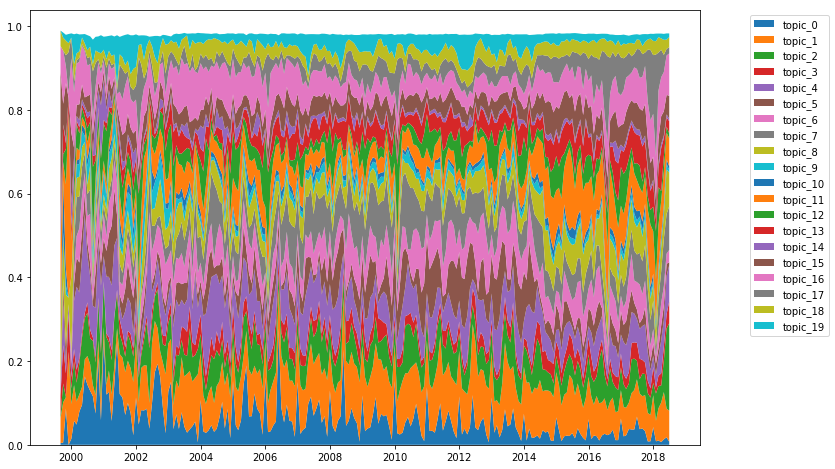

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.stackplot(a.index, a.T.values, labels=list(a.columns))
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

### Слова в топиках

In [22]:
ldamodel1.print_topics()

[(0,
  '0.041*"6" + 0.031*"турнир" + 0.021*"шарапов" + 0.016*"теннисистка" + 0.015*"россиянка" + 0.014*"7" + 0.014*"4" + 0.014*"матч" + 0.013*"3" + 0.012*"счёт"'),
 (1,
  '0.028*"тренер" + 0.026*"команда" + 0.025*"клуб" + 0.015*"выступать" + 0.013*"чемпионат" + 0.012*"контракт" + 0.011*"главный" + 0.011*"руководство" + 0.010*"сборный" + 0.010*"сезон"'),
 (2,
  '0.044*"россия" + 0.043*"сборный" + 0.041*"команда" + 0.037*"чемпионат" + 0.036*"сборная" + 0.034*"мир" + 0.027*"матч" + 0.027*"турнир" + 0.017*"финал" + 0.014*"россиянин"'),
 (3,
  '0.063*"миллион" + 0.036*"евро" + 0.033*"клуб" + 0.023*"доллар" + 0.018*"тысяча" + 0.014*"сумма" + 0.012*"мира-2018" + 0.010*"английский" + 0.010*"игрок" + 0.009*"зарплата"'),
 (4,
  '0.051*"счёт" + 0.041*"минута" + 0.037*"матч" + 0.031*"1" + 0.027*"встреча" + 0.023*"0" + 0.023*"2" + 0.019*"завершиться" + 0.019*"мяч" + 0.016*"победа"'),
 (5,
  '0.021*"нхл" + 0.021*"матч" + 0.021*"шайба" + 0.020*"хоккейный" + 0.019*"лига" + 0.017*"хоккеист" + 0.012*"за

### Топ слова.

In [23]:
word_counts = {}
for s in tqdm_notebook(doc_term_matrix):
    for w in s:
        if w[0] not in word_counts:
            word_counts[w[0]] = w[1]
        else:
            word_counts[w[0]] += w[1]

In [24]:
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [25]:
for w in sorted_word_counts[:50]:
    print(f'{dictionary[w[0]]} - {w[1]} times.')

матч - 84963 times.
команда - 62008 times.
чемпионат - 49799 times.
россия - 49296 times.
клуб - 44362 times.
счёт - 39923 times.
сборный - 39581 times.
мир - 35081 times.
российский - 34024 times.
игра - 32950 times.
1 - 28823 times.
место - 28423 times.
тренер - 27111 times.
победа - 26481 times.
турнир - 26127 times.
чемпион - 24927 times.
2 - 24000 times.
игрок - 22321 times.
минута - 22235 times.
встреча - 20843 times.
сборная - 20393 times.
футболист - 19731 times.
6 - 19427 times.
0 - 18171 times.
3 - 18137 times.
лига - 17982 times.
состав - 17782 times.
кубок - 17431 times.
сайт - 17402 times.
состояться - 17261 times.
футбольный - 16914 times.
финал - 16754 times.
футбол - 16478 times.
очки - 16163 times.
четыре - 15902 times.
первое - 15867 times.
россиянин - 15842 times.
выиграть - 14971 times.
московский - 14866 times.
официальный - 14780 times.
главный - 14562 times.
олимпийский - 14141 times.
4 - 14055 times.
спортсмен - 14043 times.
последний - 13701 times.
цска - 13543